In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [3]:
train_original = train.copy()
test_original = test.copy()

In [4]:
train_original

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


In [5]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

## Feature Extraction

### Change data type to DateTime

In [9]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')

In [10]:
for dataframe in (train, test, train_original, test_original):
    dataframe['year'] = dataframe.Datetime.dt.year
    dataframe['month'] = dataframe.Datetime.dt.month
    dataframe['day'] = dataframe.Datetime.dt.day
    dataframe['hour'] = dataframe.Datetime.dt.hour

In [12]:
train['day of the week'] = train['Datetime'].dt.dayofweek

In [13]:
temp = train['Datetime']

In [14]:
def applyer(row):
    if row.dayofweek ==  5 or row.dayofweek == 6:
        return 1
    else:
        return 0
    
temp2 = train['Datetime'].apply(applyer)
train['weekend'] = temp2

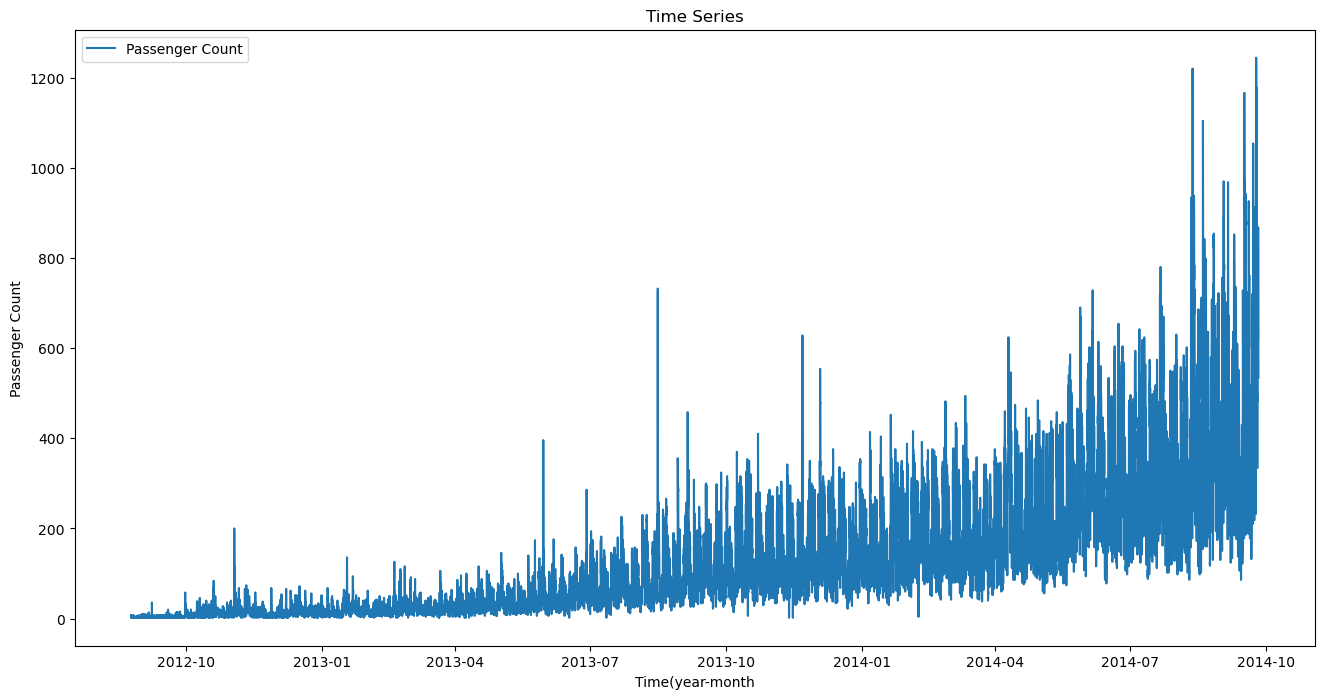

In [16]:
train.index = train['Datetime']
df = train.drop('ID', axis=1)
ts = df['Count']
plt.figure(figsize=(16, 8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

## Exploratory Analysis

<Axes: xlabel='year'>

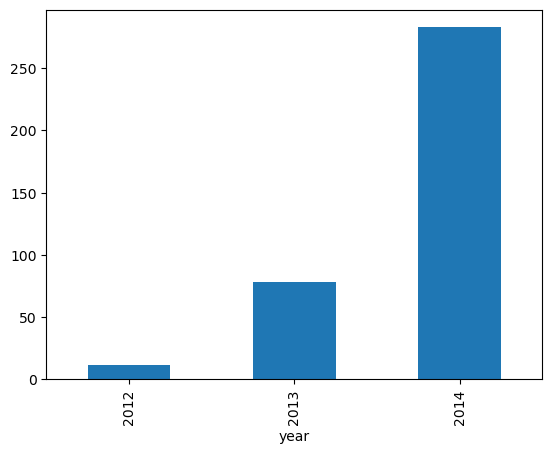

In [17]:
train.groupby('year')['Count'].mean().plot.bar()

<Axes: title={'center': 'Passenger Count (Monthly)'}, xlabel='year,month'>

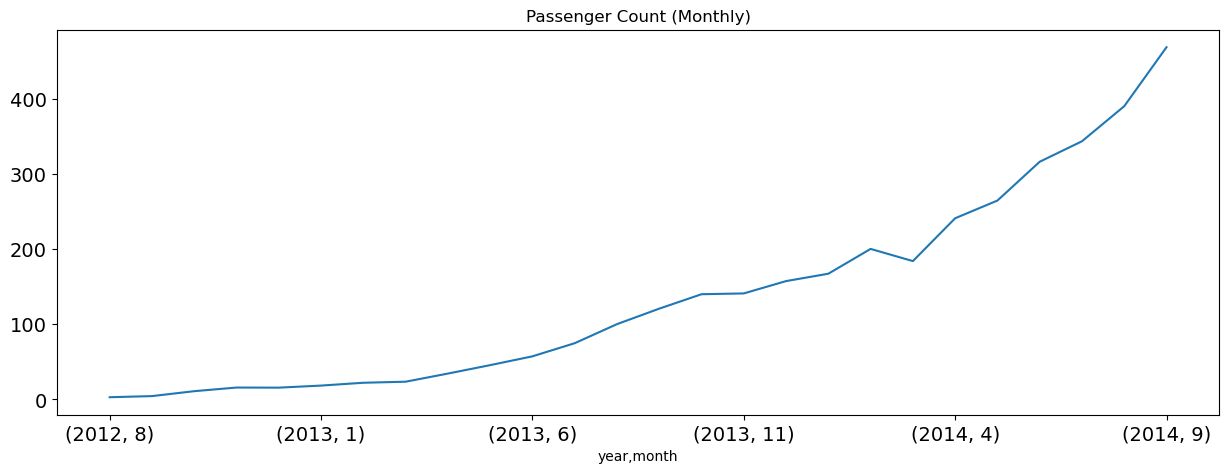

In [18]:
temp = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15, 5), title='Passenger Count (Monthly)', fontsize=14)

<Axes: xlabel='day'>

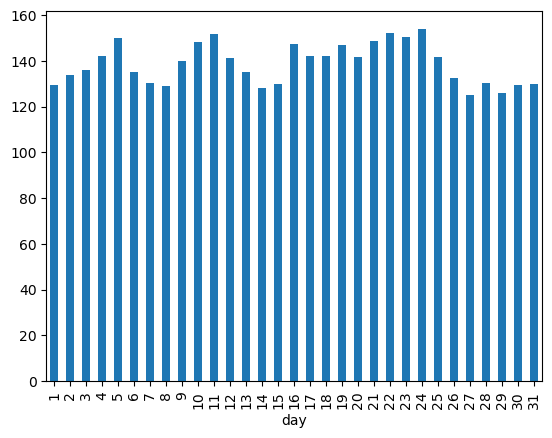

In [19]:
train.groupby('day')['Count'].mean().plot.bar()

<Axes: xlabel='hour'>

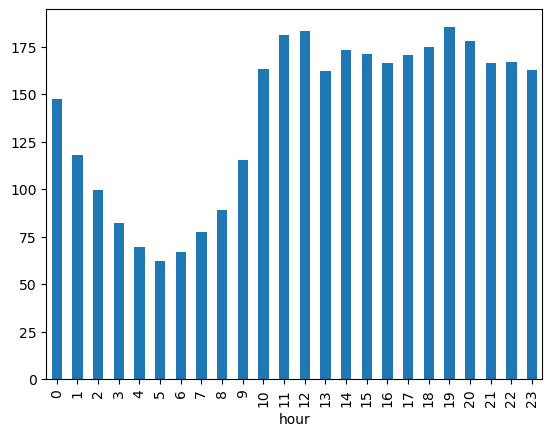

In [20]:
train.groupby('hour')['Count'].mean().plot.bar()

<Axes: xlabel='weekend'>

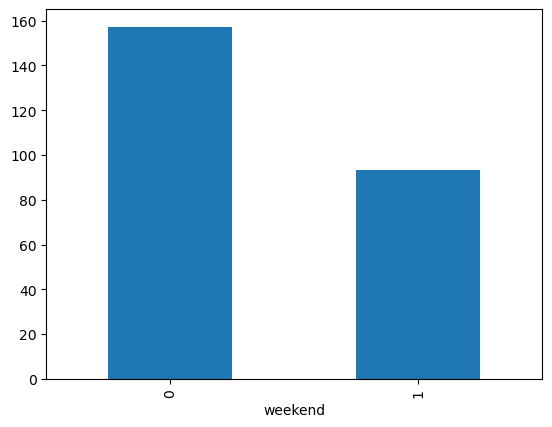

In [21]:
train.groupby('weekend')['Count'].mean().plot.bar()

<Axes: xlabel='day of the week'>

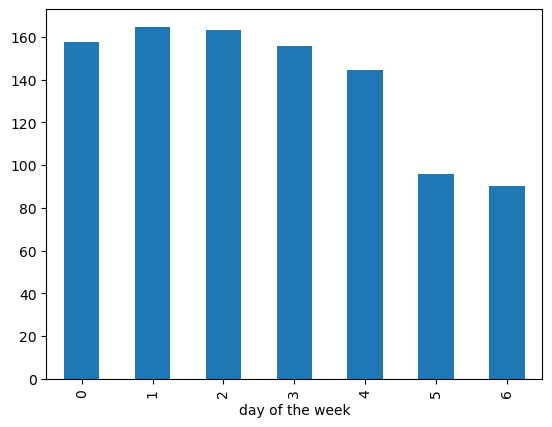

In [22]:
train.groupby('day of the week')['Count'].mean().plot.bar()

In [24]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

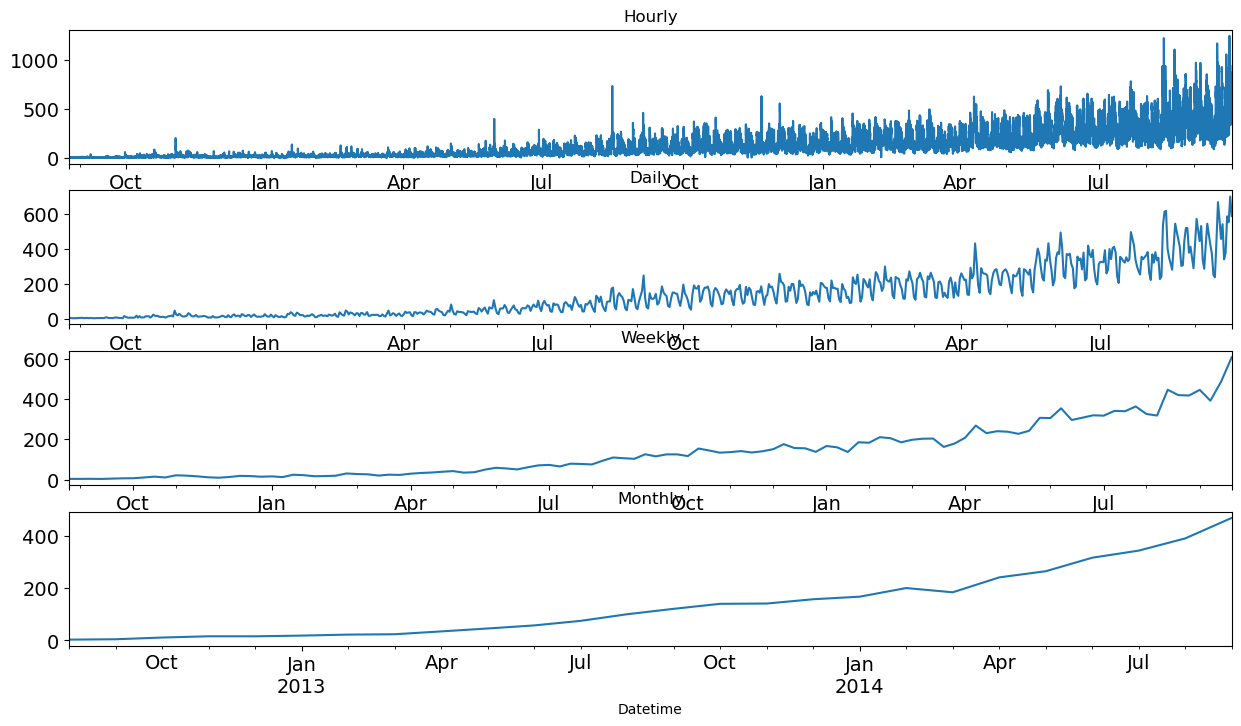

In [25]:
fig, axs = plt.subplots(4, 1)
hourly.Count.plot(figsize=(15, 8), title='Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15, 8), title='Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15, 8), title='Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15, 8), title='Monthly', fontsize=14, ax=axs[3])
plt.show()

In [26]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

train = daily

# Modeling Techniques and Evaluation

## Splitting the data into training and validation sets

In [32]:
import sklearn
from sklearn.model_selection import train_test_split

In [33]:
training, validation = train_test_split(train, test_size=0.12, random_state=42, shuffle=False, stratify=None)

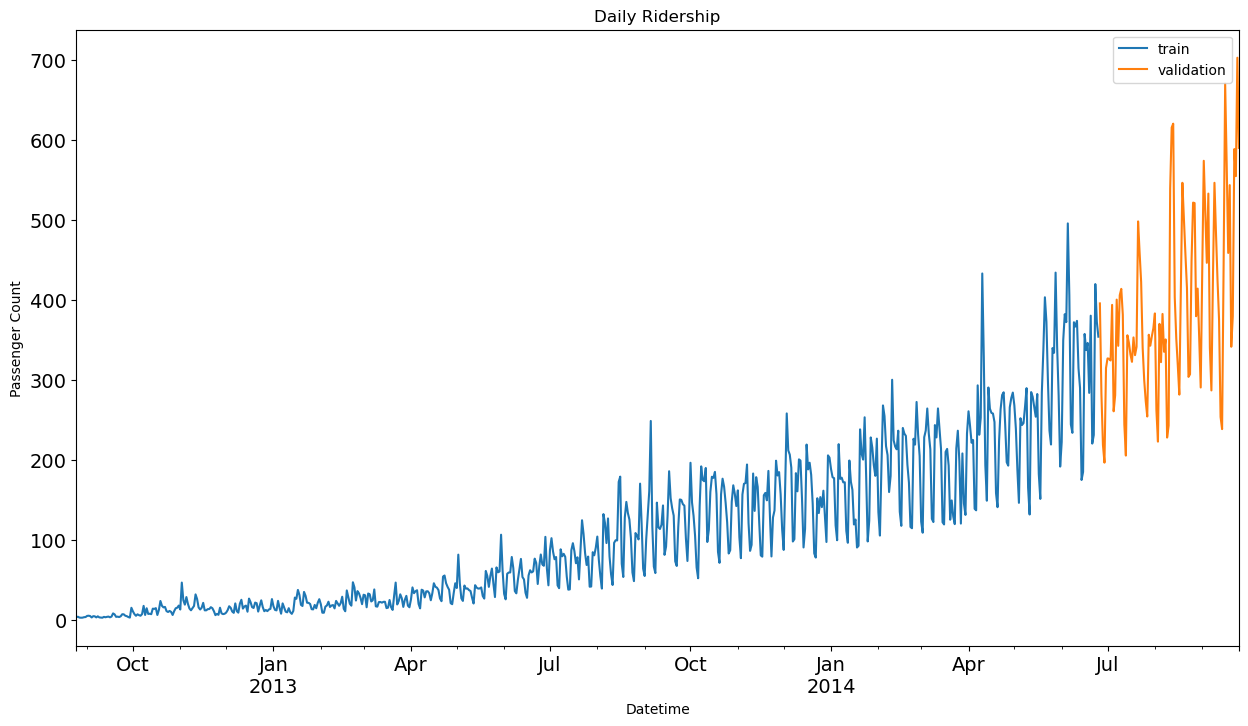

In [36]:
training.Count.plot(figsize=(15, 8), title='Daily Ridership', fontsize=14, label='train')
validation.Count.plot(figsize=(15, 8), title='Daily Ridership', fontsize=14, label='validation')
plt.xlabel("Datetime")
plt.ylabel("Passenger Count")
plt.legend(loc='best')
plt.show()

## Time Series Forecasting Models

### 1) Naive Approach

In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction.

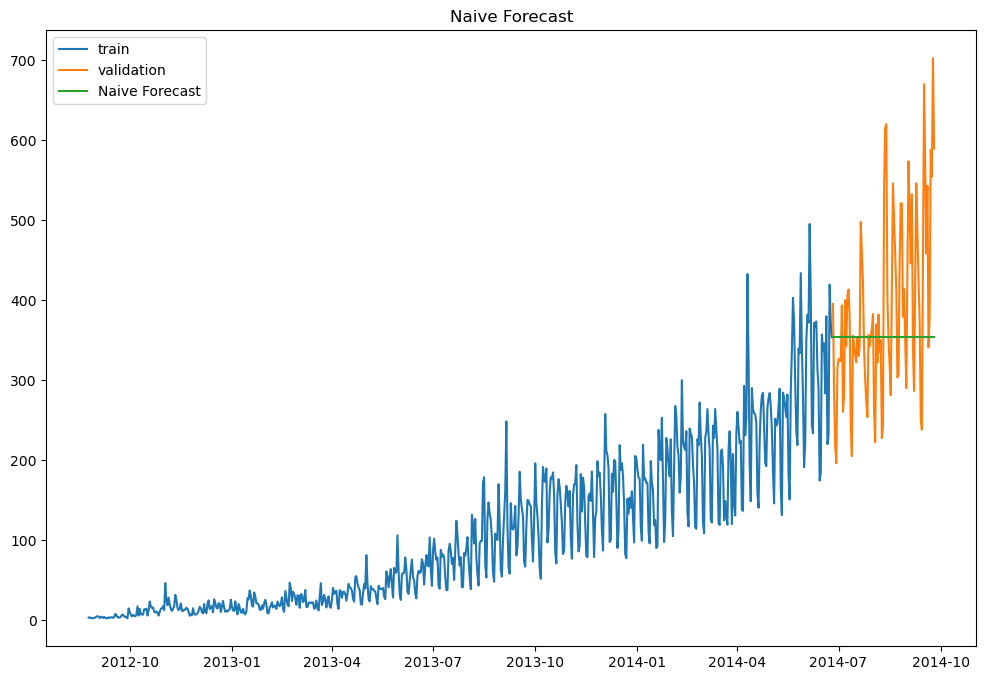

In [37]:
dd = np.asarray(training.Count)
y_hat = validation.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12, 8))
plt.plot(training.index, training['Count'], label='train')
plt.plot(validation.index, validation['Count'], label='validation')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(validation.Count, y_hat.naive))
print(rms)

116.70299188631536


### 2) Moving Average

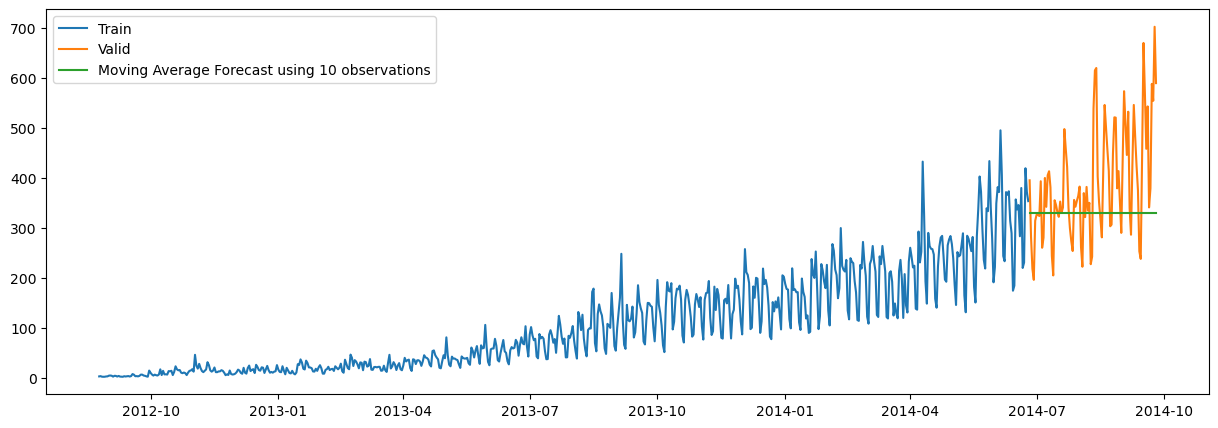

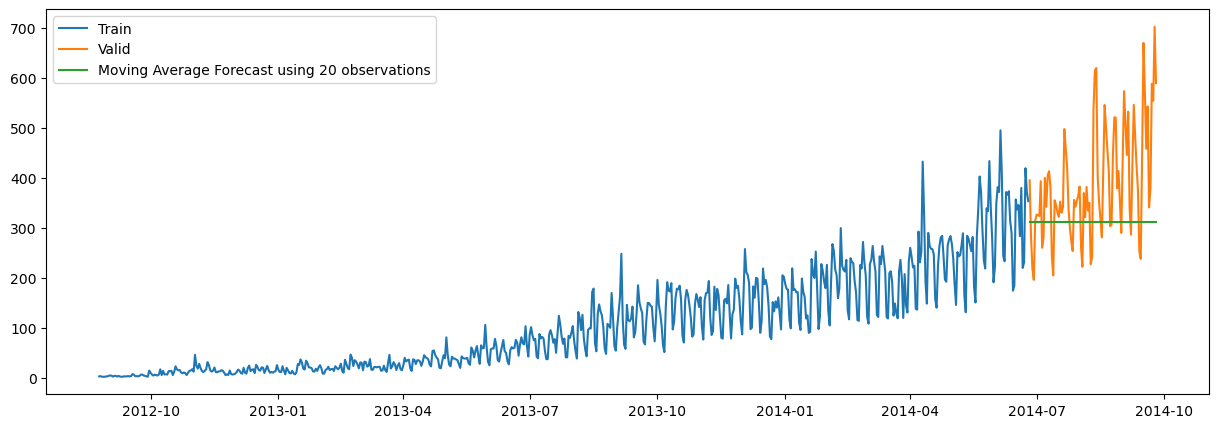

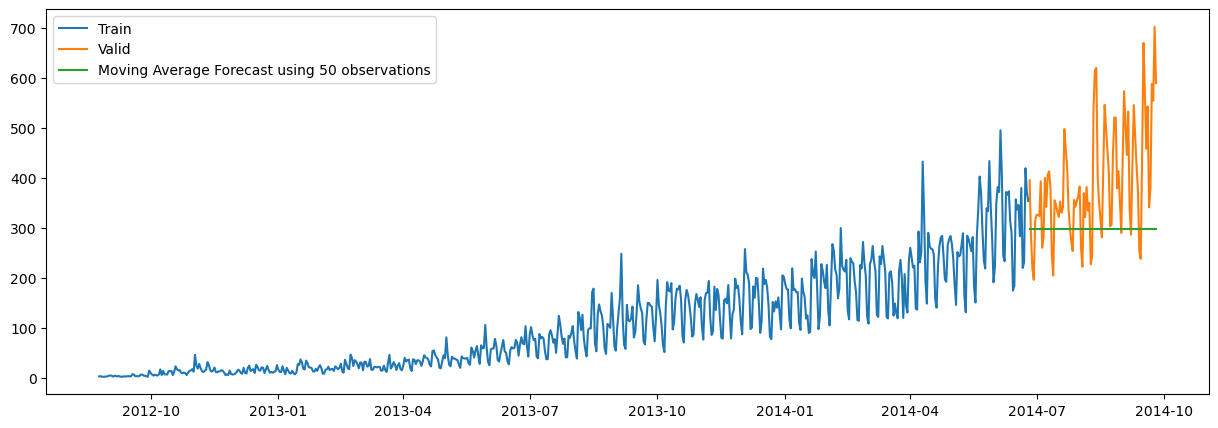

In [39]:
y_hat_avg = validation.copy()
y_hat_avg['moving_avg_forecast'] = training['Count'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'],
         label='Moving Average Forecast using 10 observations')

plt.legend(loc='best')
plt.show()

y_hat_avg = validation.copy()
y_hat_avg['moving_avg_forecast'] = training['Count'].rolling(20).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'],
         label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()

y_hat_avg = validation.copy()
y_hat_avg['moving_avg_forecast'] = training['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'],
         label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()

In [40]:
rms = sqrt(mean_squared_error(validation.Count, y_hat_avg.moving_avg_forecast))
print(rms)

143.44255984118618


### 3) Simple Exponential Smoothing

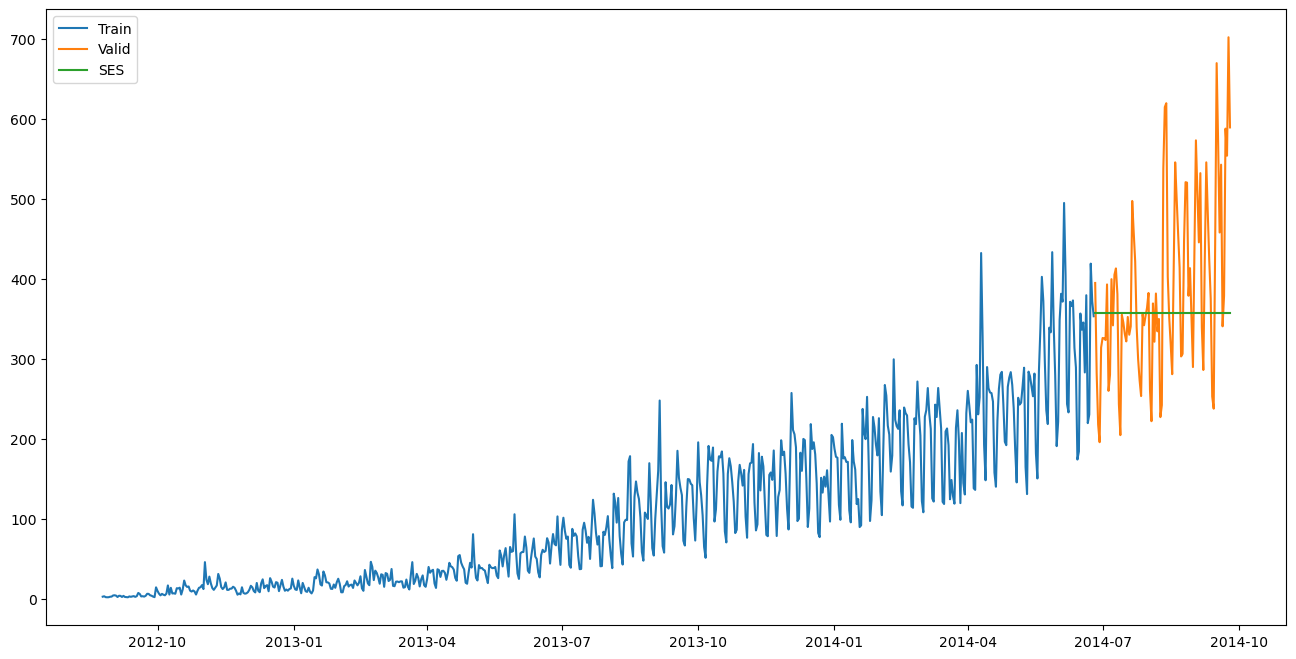

115.54719361532071


In [41]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = validation.copy()
fit2 = SimpleExpSmoothing(np.asarray(training['Count'])).fit(smoothing_level=0.6, optimized=False) 

y_hat_avg['SES'] = fit2.forecast(len(validation))

plt.figure(figsize=(16,8))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(validation.Count, y_hat_avg.SES))
print(rms)

### 4) Holt's Linear Trend Model

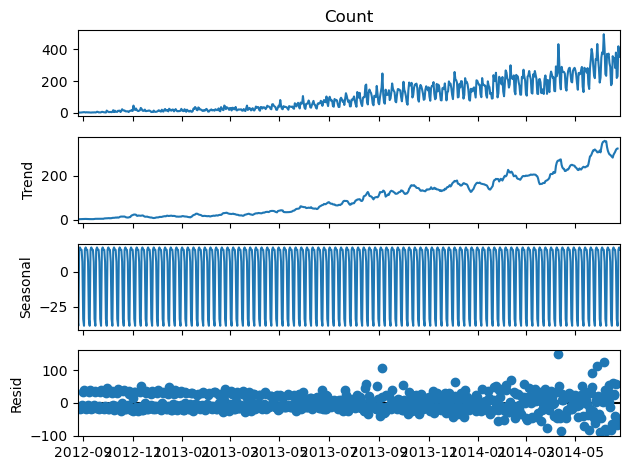

In [42]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(training.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

C:\Users\peter\miniconda3\envs\Ledgr\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


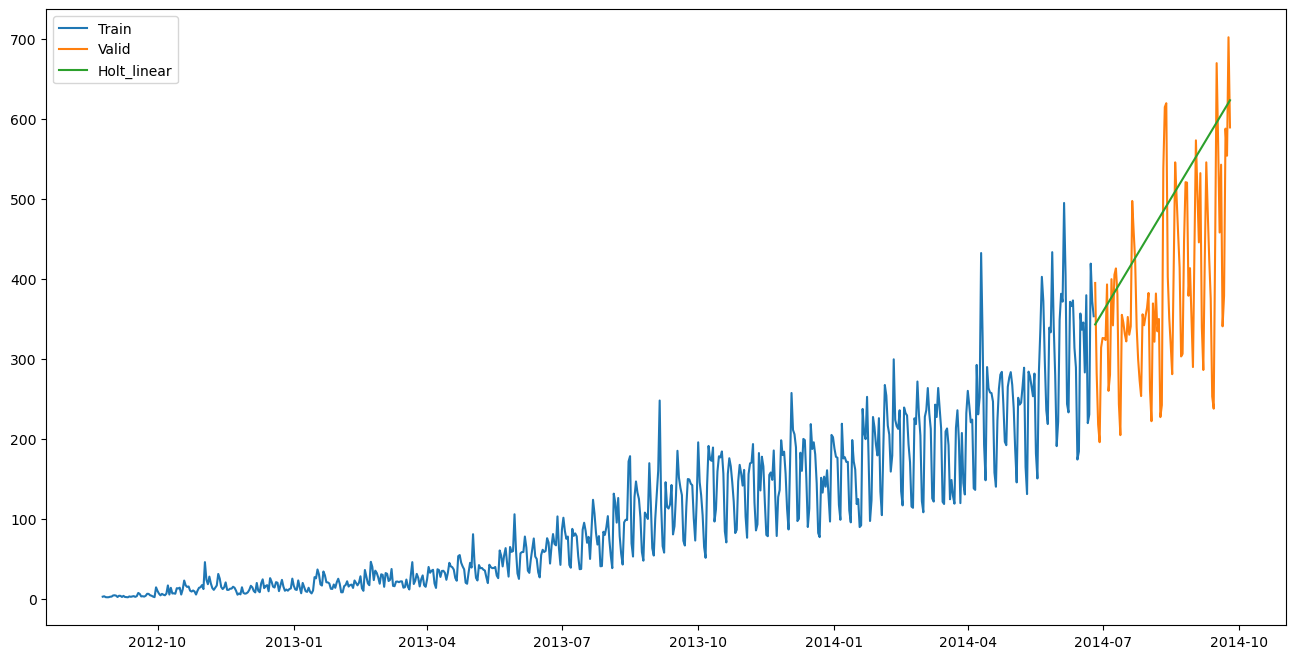

In [43]:
y_hat_avg = validation.copy()
fit1 = Holt(np.asarray(training['Count'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(validation))
plt.figure(figsize=(16,8))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [45]:
rms = sqrt(mean_squared_error(validation.Count, y_hat_avg.Holt_linear))
print(rms)

135.66726189172724
